# Fit the OAK model and unconstrained model to a 1D dataset generated from a GP

In [3]:
%run Imports.py

All packages loaded successfully.


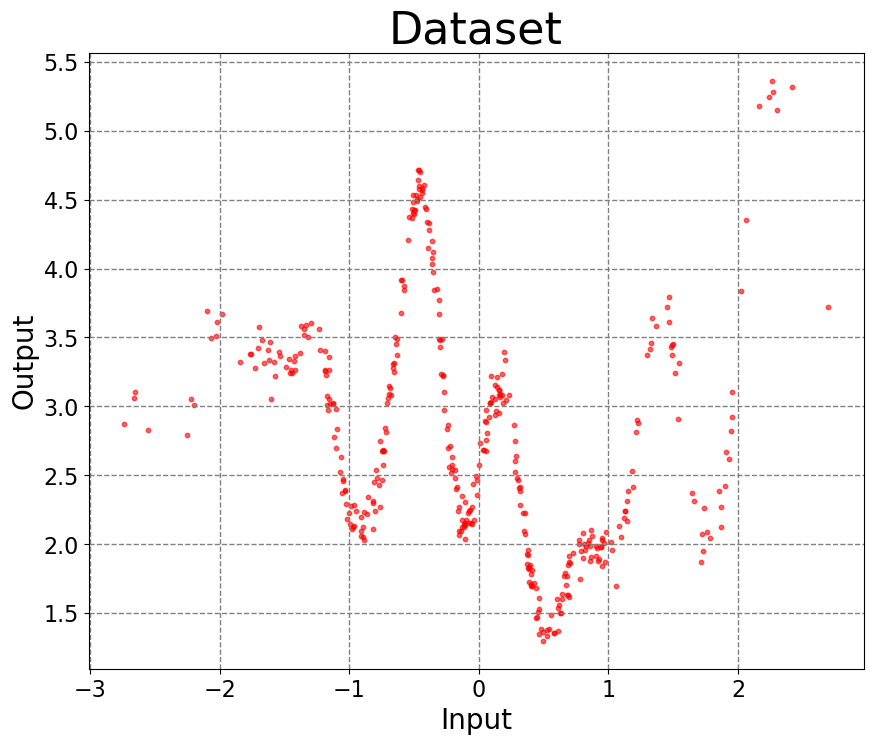

In [4]:
# --- Sample from a GP --- 

lengthscale = 0.2
variance = 1
noise = 0.1

sigma0 = 1e-3
sigma1 = 1

np.random.seed(0)
tf.random.set_seed(0)

kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)
mean_function = gpflow.mean_functions.Constant(c=3.0)

X_grid = np.linspace(-4,4,1000).reshape(-1,1)
X_grid_tf = tf.convert_to_tensor(X_grid, dtype=tf.float64)


mean = mean_function(X_grid_tf)
cov = kernel.K(X_grid_tf)

L = tf.linalg.cholesky(cov + tf.eye(tf.shape(cov)[0], dtype=tf.float64) * 1e-6)
z = tf.random.normal([tf.shape(X_grid_tf)[0], 1], dtype=tf.float64)
f_samples = (mean + tf.matmul(L, z)).numpy().squeeze()

X_data = np.random.normal(loc=0.0, scale=1.0, size=(500,1))
f_interp = interp1d(X_grid.flatten(), f_samples, fill_value="extrapolate")
Y_data = f_interp(X_data.flatten()).reshape(-1,1) + np.random.normal(0, noise, size=500).reshape(-1,1)


kf = KFold(n_splits=5, shuffle=True, random_state=0)
X_train, X_test, Y_train, Y_test = None, None, None, None
for train_index, test_index in kf.split(X_data):
    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]
    break


# -- Plot the Dataset --- 

plt.figure(figsize=(10, 8))
plt.scatter(X_train, Y_train, s=10, color='red', alpha=0.6)
plt.title("Dataset")
plt.xlabel("Input")
plt.ylabel("Output")
plt.grid(True)
plt.show()

In [5]:
# --- Create Unconstrained model ---

data = (X_train, Y_train)
model = create_model_oak(
    data=data,
    max_interaction_depth=1,
    constrain_orthogonal=False,
    share_var_across_orders=True,
    use_sparsity_prior=False,
)


# --- Train model ---

opt = Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))


# --- Print model summary ---

gpflow.utilities.print_summary(model)
print(model.training_loss())

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.215664   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.variances[0]            │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 9.06371    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.variances[1]            │ Parameter │ Softplus         │         │ True        │ ()      │ float64

In [6]:
# --- Calculate the component means ---

x1_plot = np.linspace(-5, 5, 100).reshape(-1,1)
X_test_tf = tf.convert_to_tensor(x1_plot, dtype=tf.float64)
X_test_tf = tf.reshape(X_test_tf, [-1, 1])

alpha = get_model_sufficient_statistics(model, get_L=False)
selected_dims, kernel_list = get_list_representation(model.kernel, num_dims=1)
K = model.kernel.K(X_train, X_train) + tf.eye(X_train.shape[0], dtype=tf.float64) * model.likelihood.variance.numpy()


mu0 = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))
mu1 = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))
mu = eval_component(model.kernel, alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))



# --- Calculate the component variances ---

# Variance for f0
var_f0_tensor = get_component_variance(kernel_list[0], K, X_test_tf, X_train)
var_f0 = var_f0_tensor.numpy()
std_f0_oak = np.sqrt(var_f0).reshape(-1,1)

# Variance for f1
var_f1_tensor = get_component_variance(kernel_list[1], K, X_test_tf, X_train)
var_f1 = var_f1_tensor.numpy()
std_f1_oak = np.sqrt(var_f1).reshape(-1,1)

# Variance for the overall model
var_overall_tensor = get_component_variance(model.kernel, K, X_test_tf, X_train)
var_overall = var_overall_tensor.numpy()
std_f_oak = np.sqrt(var_overall).reshape(-1,1)



low1 = (mu1 - 2*std_f1_oak).reshape(100)
high1 = (mu1 + 2*std_f1_oak).reshape(100)
low0 = (mu0 - 2*std_f0_oak).reshape(100)
high0 = (mu0 + 2*std_f0_oak).reshape(100)
low = (mu - 2*std_f_oak).reshape(100)
high = (mu + 2*std_f_oak).reshape(100)


In [7]:
# --- Create OAK model ---

data = (X_train, Y_train)
oak = create_model_oak(
    data=data,
    max_interaction_depth=1,
    constrain_orthogonal=True,
    share_var_across_orders=True,
    use_sparsity_prior=False,
)


# --- Train model ---

opt = Scipy()
opt.minimize(oak.training_loss, oak.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))


# --- Print model summary ---

gpflow.utilities.print_summary(oak)
print(oak.training_loss().numpy())

╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.217399  │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.variances[0]                        │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 7.68506   │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.variances[1]         

In [8]:
# --- Calculate the component means ---

x1_plot = np.linspace(-5, 5, 100).reshape(-1,1)
X_test_tf = tf.convert_to_tensor(x1_plot, dtype=tf.float64)
X_test_tf = tf.reshape(X_test_tf, [-1, 1])

alpha = get_model_sufficient_statistics(oak, get_L=False)
selected_dims, kernel_list = get_list_representation(oak.kernel, num_dims=1)
K = oak.kernel.K(X_train, X_train) + tf.eye(X_train.shape[0], dtype=tf.float64) * oak.likelihood.variance.numpy()

mu0_oak = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))
mu1_oak = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))
mu_oak = eval_component(oak.kernel, alpha, tf.convert_to_tensor(x1_plot, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64))



# --- Calculate the component variances ---

# Variance for f0
var_f0_tensor = get_component_variance(kernel_list[0], K, X_test_tf, X_train)
var_f0 = var_f0_tensor.numpy()
std_f0_oak = np.sqrt(var_f0).reshape(-1,1)

# Variance for f1
var_f1_tensor = get_component_variance(kernel_list[1], K, X_test_tf, X_train)
var_f1 = var_f1_tensor.numpy()
std_f1_oak = np.sqrt(var_f1).reshape(-1,1)

# Variance for the overall model
var_overall_tensor = get_component_variance(oak.kernel, K, X_test_tf, X_train)
var_overall = var_overall_tensor.numpy()
std_f_oak = np.sqrt(var_overall).reshape(-1,1)


low1_oak = (mu1_oak - 2*std_f1_oak).reshape(100)
high1_oak = (mu1_oak + 2*std_f1_oak).reshape(100)
low0_oak = (mu0_oak - 2*std_f0_oak).reshape(100)
high0_oak = (mu0_oak + 2*std_f0_oak).reshape(100)
low_oak = (mu_oak - 2*std_f_oak).reshape(100)
high_oak = (mu_oak + 2*std_f_oak).reshape(100)

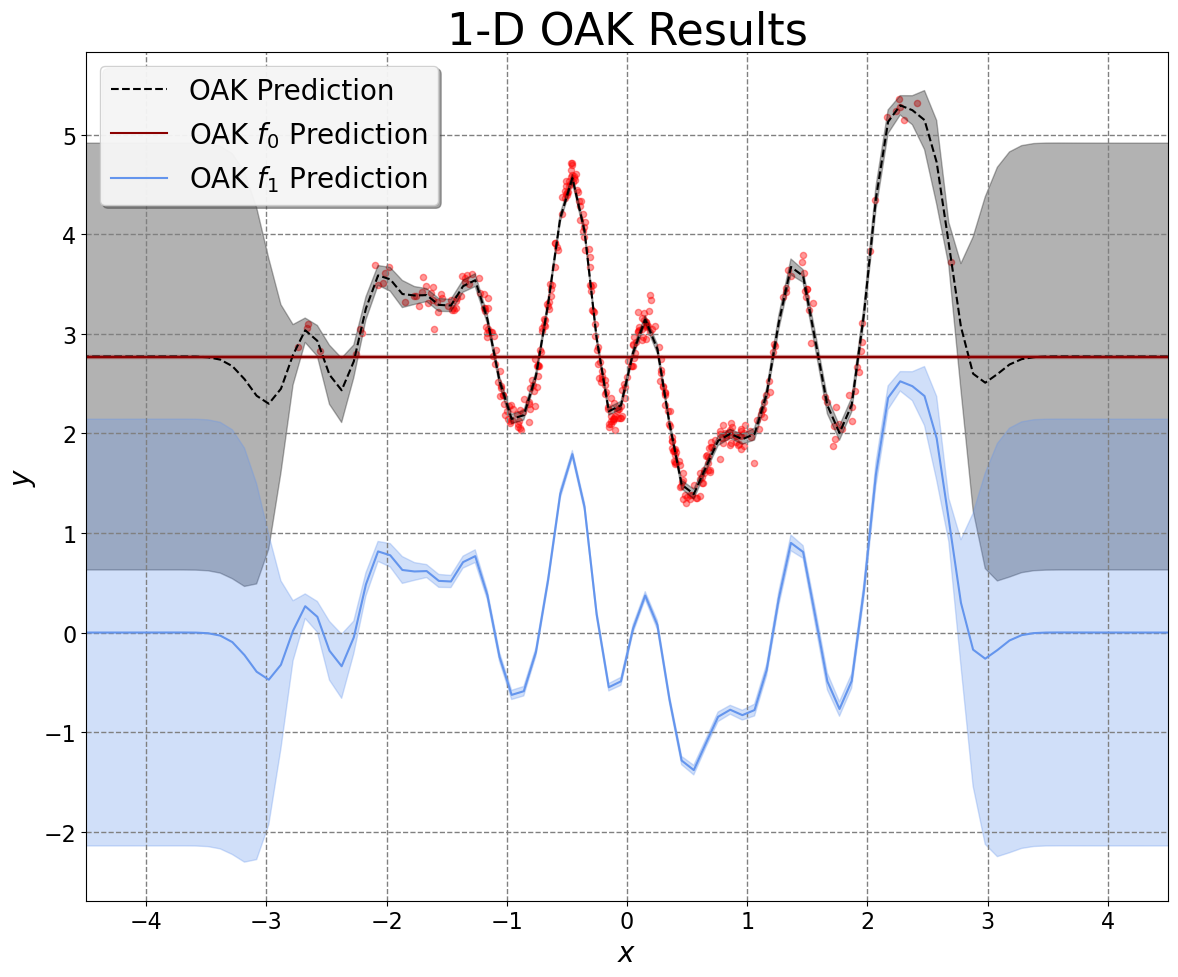

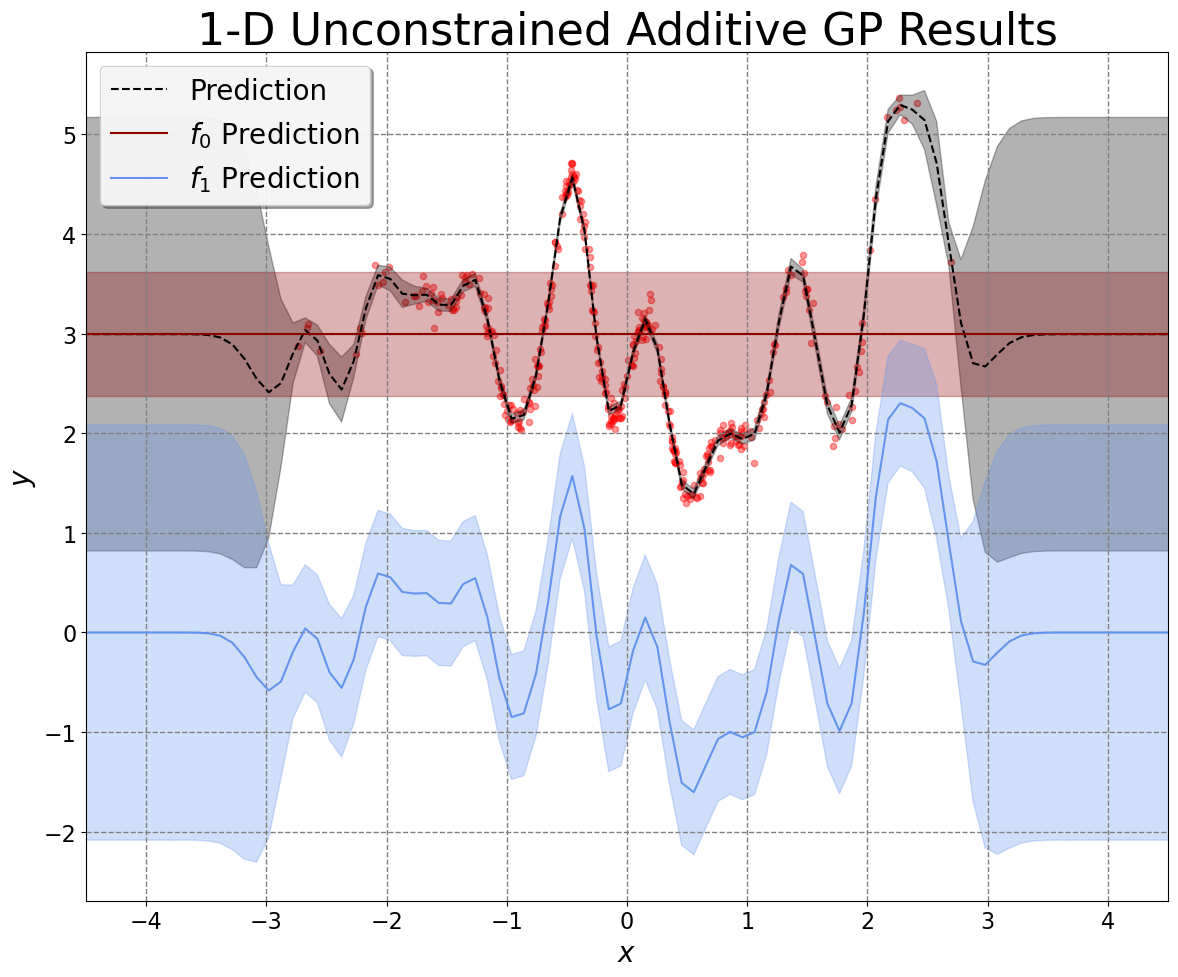

In [9]:
plt.figure(figsize=(12,10))
plt.scatter(X_train, Y_train, s=20, color='red', alpha=0.4)
plt.plot(x1_plot, mu_oak, color='black', linestyle='--', label='OAK Prediction')
plt.fill_between(x1_plot.reshape(100), low_oak, high_oak, color='black', alpha=0.3)

plt.plot(x1_plot.reshape(100), mu0_oak, color='darkred', label='OAK $f_0$ Prediction')
plt.fill_between(x1_plot.reshape(100), low0_oak, high0_oak, color='darkred', alpha=0.3)
plt.plot(x1_plot.reshape(100), mu1_oak, color='cornflowerblue', label='OAK $f_1$ Prediction')
plt.fill_between(x1_plot.reshape(100), low1_oak, high1_oak, color='cornflowerblue', alpha=0.3)

plt.title('1-D OAK Results')
plt.legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)
plt.xlim([-4.5,4.5])
plt.grid(True)
plt.ylabel('$y$')
plt.xlabel('$x$')
plt.tight_layout()
plt.show()




plt.figure(figsize=(12,10))
plt.scatter(X_train, Y_train, s=20, color='red', alpha=0.4)
plt.plot(x1_plot, mu, color='black', label='Prediction', linestyle='--')
plt.fill_between(x1_plot.reshape(100), low, high, color='black', alpha=0.3)

plt.plot(x1_plot, mu0, label='$f_0$ Prediction', color='darkred')#palevioletred
plt.fill_between(x1_plot.reshape(100), low0, high0, color='darkred', alpha=0.3)
plt.plot(x1_plot, mu1, label='$f_1$ Prediction', color='cornflowerblue')
plt.fill_between(x1_plot.reshape(100), low1, high1, color='cornflowerblue', alpha=0.3)


plt.title('1-D Unconstrained Additive GP Results')
plt.legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)
plt.grid(True)
plt.xlim([-4.5,4.5])
plt.ylabel('$y$')
plt.xlabel('$x$')
plt.tight_layout()
plt.show()